# Emotion detection in crowds with YOLO


In [4]:
!pip install --quiet opencv-python ultralytics
!pip install --quiet iterative-stratification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.7 MB/s eta 0:00:00


In the next cell we set-up all the directories we will use for the training process. Make sure they match your configuration.

In [1]:
import pandas as pd
import ast
import os
from pathlib import Path
from google.colab import drive

drive.mount("/content/drive")
%cd 'drive/Othercomputers/My Computer (1)/EmotionTeller-github'

from utilsJ import *

data_root       = Path('Data')                # Folder where all data sources are stored
dataset_path    = data_root/'ImageData'       # List of folders containing images in .jpg format
data_meta       = ['emotic-relabelled.csv',
                'hgel-relabelled.csv']        # List of metadata corresponding to previous list of folders in .csv format. In our case we relabelled some of the data, so this is different from original metadata.
meta_root       = Path('Metadata')            # Folder where the previous .csv files are located
yolo_dir        = Path('YOLO_training')       # Folder where the results and data splitting will take place for YOLO
os.makedirs(yolo_dir, exist_ok=True)

Mounted at /content/drive
/content/drive/Othercomputers/My Computer (1)/EmotionTeller-github


The metadata for the train set will be stored in the dataframe `df`.

In [2]:
df = pd.read_csv(meta_root/'train_meta.csv')
df['objects'] = df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
df['file_exists'] = df.apply(lambda x: os.path.exists(dataset_path/x.file_name),axis = 1)

# Drop rows where the file does not exist
df = df[df.file_exists]
df.drop(columns=['file_exists'], inplace=True)

df.head()

,file_name,objects,original_height,original_width,emotions
0,2w4w14gc7v0zzlo2hr.jpg,"{'bbox': [[53.203433030794265, 17.615104049146...",300,361,['Sad']
1,30nuw6i66lmickmbly.jpg,"{'bbox': [[26.798646725660358, 15.553243651943...",500,489,['Sad']
2,6ypnlgwpdwm4cxhzyq.jpg,"{'bbox': [[39.807704879496356, 5.2996237628844...",393,233,['Disgust']
3,7yfw4gdcdak0kdvqu2.jpg,"{'bbox': [[47.60784313725491, 6.43835340508561...",184,274,['Sad']
4,9uq1l58tusi8vij6ju.jpg,"{'bbox': [[38.745098039215634, 17.137253719272...",200,300,['Sad']


In [5]:
import cv2
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Since our data is not balanced emotion-wise, we do an stratified train-val split. This will keep the same proportion of emotions in the train and validation set.

In [6]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

In [7]:
mlb = MultiLabelBinarizer()

X = df[['file_name']]
y = mlb.fit_transform(df['emotions'])

mss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
idx = np.arange(len(df))

(train_idx, test_idx), = mss.split(idx, y)

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df  = df.iloc[test_idx].reset_index(drop=True)

The emotions to be detected by the model.

In [8]:
emo_dic = {'Neutral':0,'Happy':1,'Surprise':2,'Sad':3,'Angry':4,'Fear':5,'Disgust':6}

To train the model, we our data needs to be in `YOLO format`. This requires a `.yaml` file which contains the relative path for the train and validation set in addition to the classes of objects to be detected. The every training image should be placed in the `images/train` folder, while the corresponding labels should be saved in a `.txt` file with the same name in the `labels/train` folder. The same thing should be done for the validation set. For example, the file structure should look like this:

```bash
YOLO_training
├─ data.yaml
├─ images
│  ├─ train
│  │  ├─image1.jpg
│  │  └─image2.jpg
│  └─ val
│     ├─image3.jpg
│     └─image4.jpg
└─ labels
   ├─ train
   │  ├─image1.txt
   │  └─image2.txt
   └─ val
      ├─image3.txt
      └─image4.txt
```

The cell below, transforms the data we have in `data_root` to the format outlined above.

In [9]:
import shutil
from tqdm import tqdm

# Create directories for train and validation images and labels
os.makedirs(yolo_dir/'images'/'train', exist_ok=True)
os.makedirs(yolo_dir/'labels'/'train', exist_ok=True)
os.makedirs(yolo_dir/'images'/'val', exist_ok=True)
os.makedirs(yolo_dir/'labels'/'val', exist_ok=True)

#for index, row in train_df.iterrows():

# Generate labels and copy images for the training set
for index, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Copying train files"):
    image_name = row['file_name']
    label_content = label(row)
    with open(yolo_dir/'labels'/'train'/image_name.replace('.jpg', '.txt'), 'w') as f:
        f.write(label_content)
    shutil.copy(dataset_path/image_name, yolo_dir/'images'/'train'/image_name)

#for index, row in test_df.iterrows():
# Generate labels and copy images for the validation set
for index, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Copying validation files"):
    image_name = row['file_name']
    label_content = label(row) # FIX THIS
    with open(yolo_dir/'labels'/'val'/image_name.replace('.jpg', '.txt'), 'w') as f:
        f.write(label_content)
    shutil.copy(dataset_path/image_name, yolo_dir/'images'/'val'/image_name)

print("\n Generated label files and copied images for train and validation sets.")

Copying validation files: 100%|██████████| 36/36 [00:59<00:00,  1.65s/it]


 Generated label files and copied images for train and validation sets.


We can now proceed to train the model with the baseline configuration.

In [10]:
model = YOLO('yolo11n.pt')
#model = YOLO('yolov11n-face.pt')

name = 'yolo_baseline'
#name = 'yolo_face_baseline'

results = model.train(data = yolo_dir/'data.yaml', project= yolo_dir/"runs", name= name, imgsz=1024, epochs = 200,device=0, batch = 8 ,rect= True)

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_training/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

The plots below show the result of the training.

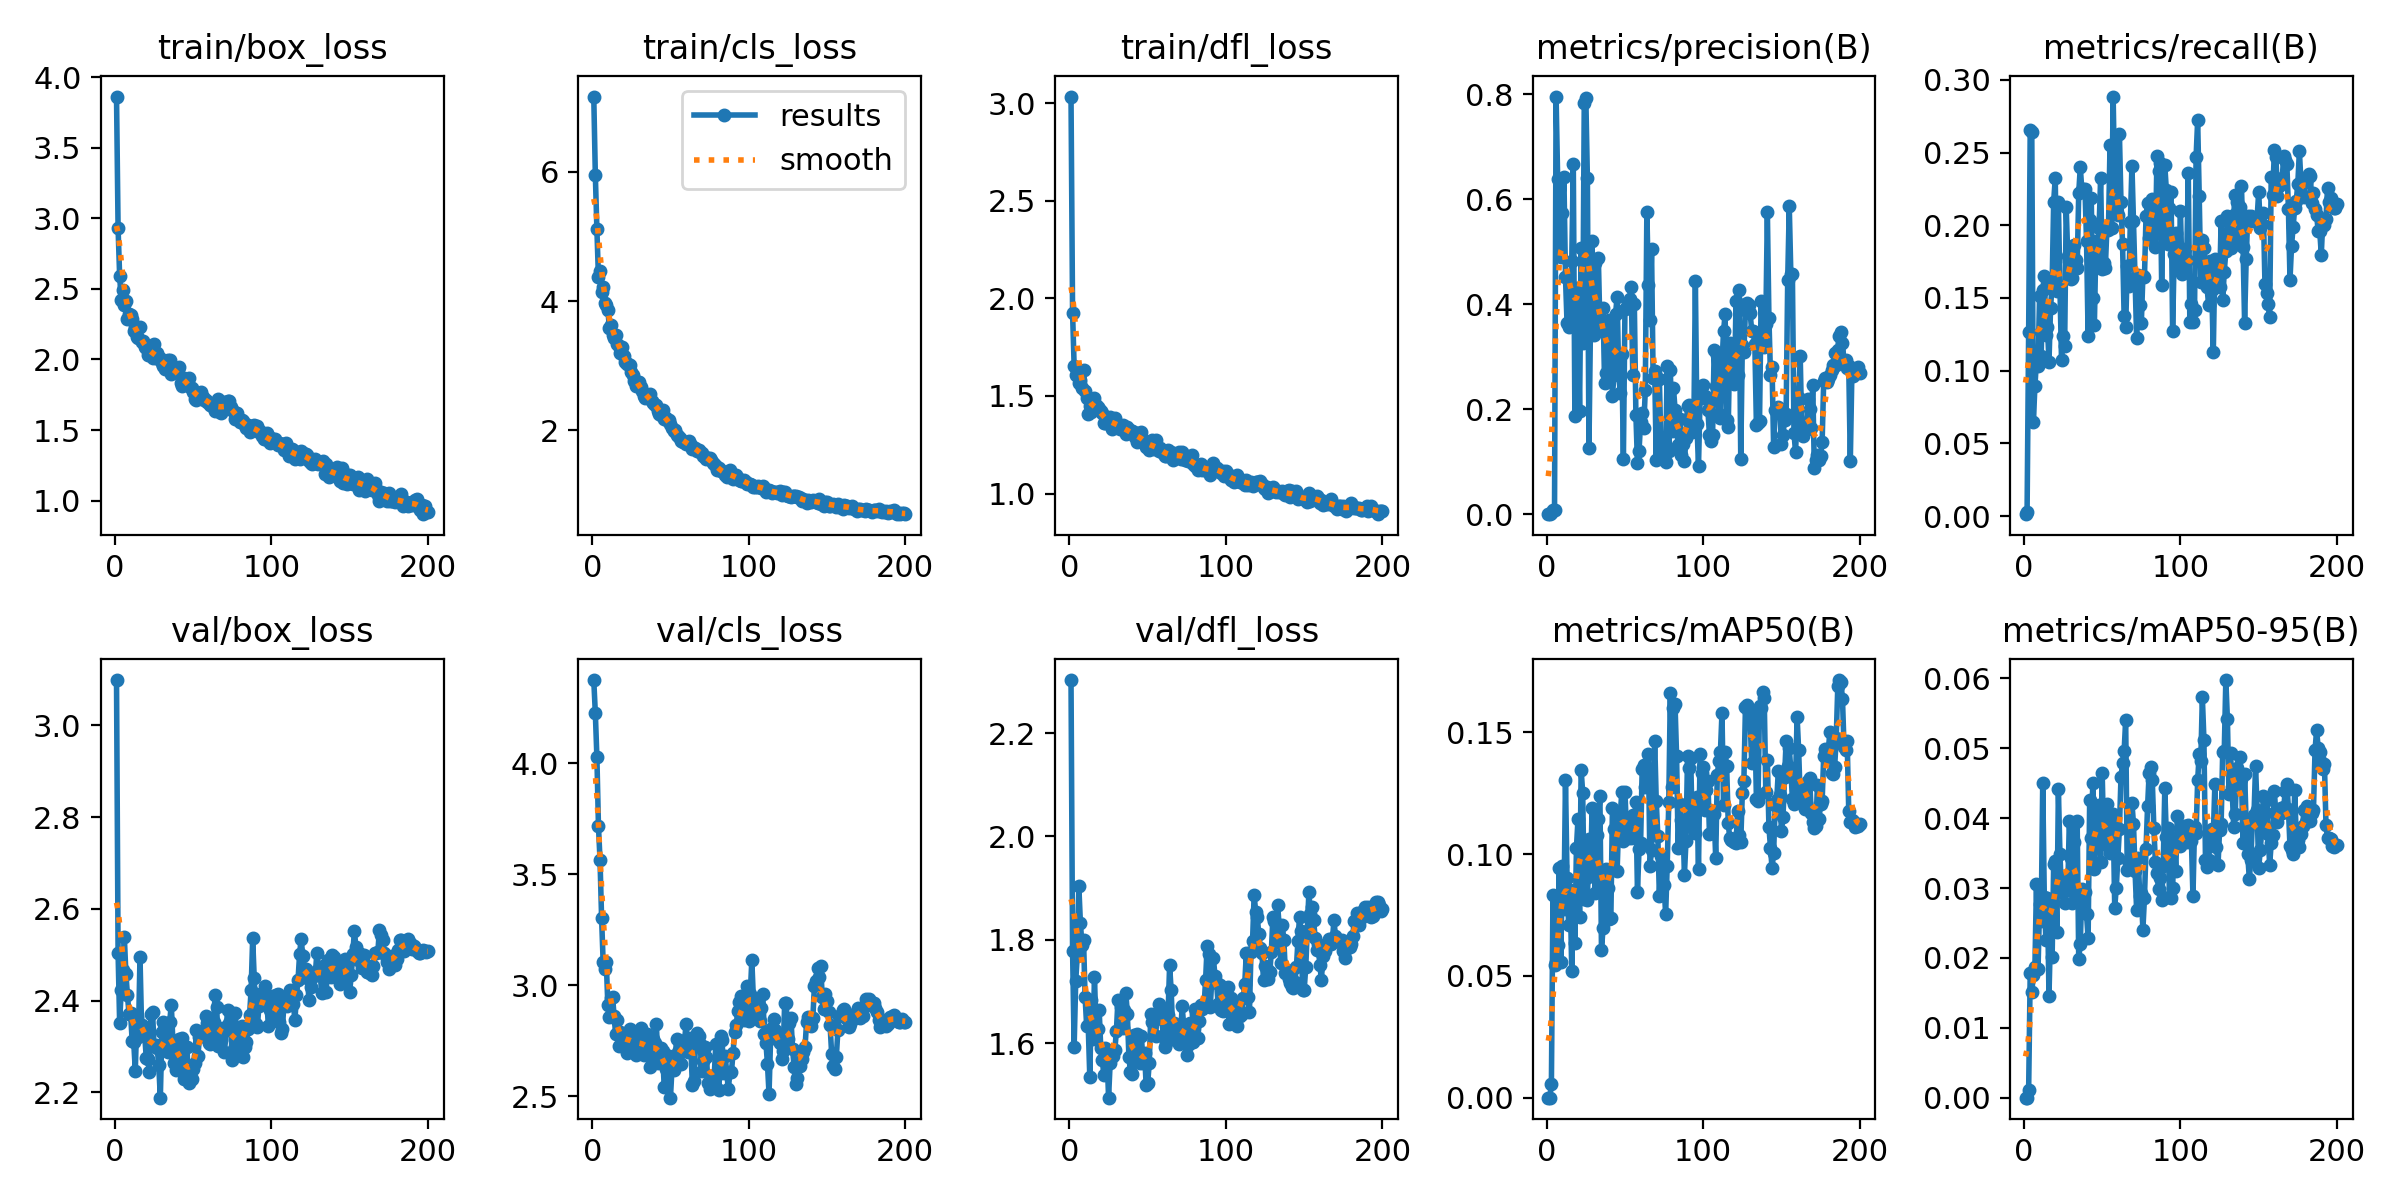

In [11]:
from IPython.display import Image, display

results_path = yolo_dir / "runs" / f"{name}" / "results.png"

display(Image(filename=results_path, width=1000))

In [12]:
model = YOLO('yolov11n-face.pt')

name = 'yolo_face_baseline'

results = model.train(data = yolo_dir/'data.yaml', project= yolo_dir/"runs", name= name, imgsz=1024, epochs = 200,device=0, batch = 8 ,rect= True, verbose=False)

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_training/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov11n-face.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_face_baseline5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

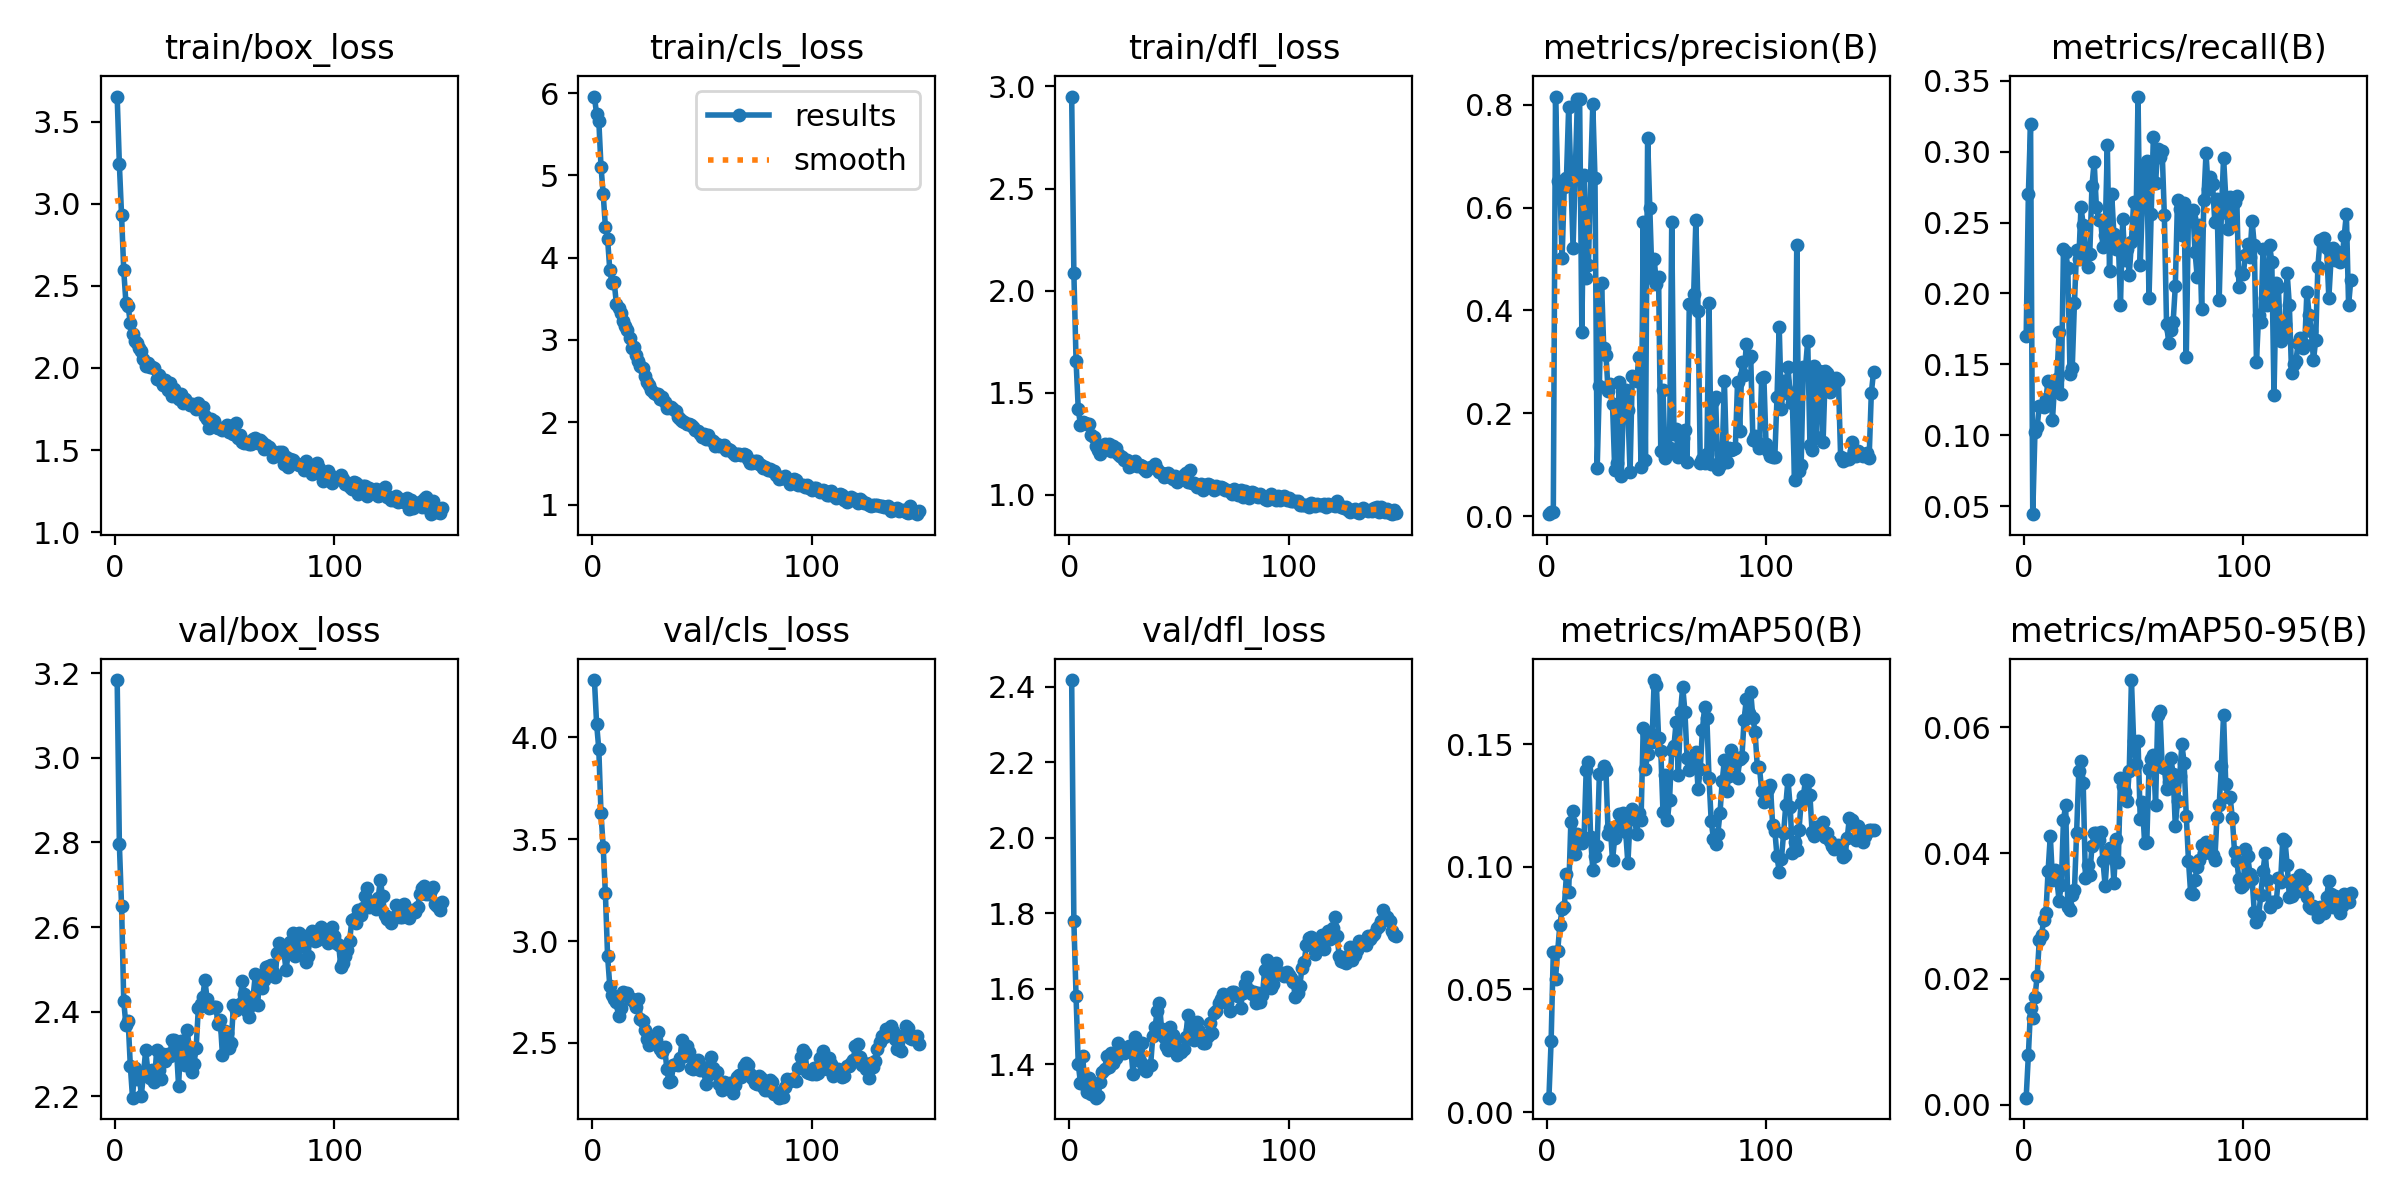

In [14]:
from IPython.display import Image, display

results_path = yolo_dir / "runs" / f"{name}5" / "results.png"

display(Image(filename=results_path, width=1000))

We use our model to predict on train and validation sets. Make sure you select the correct weights for the latest run.

In [16]:
fine_tuned = YOLO('YOLO_training/runs/yolo_baseline/weights/best.pt')

val_df['path_to_img'] = val_df.apply(lambda x: yolo_dir/'images'/'val'/x.file_name,axis=1)

train_df['path_to_img'] = train_df.apply(lambda x: yolo_dir/'images'/'train'/x.file_name,axis=1)

train_preds = fine_tuned.predict(list(train_df['path_to_img']))
val_preds = fine_tuned.predict(list(val_df['path_to_img']))


0: 1024x1024 1 Sad, 1.5ms
1: 1024x1024 1 Disgust, 1.5ms
2: 1024x1024 1 Sad, 1.5ms
3: 1024x1024 1 Sad, 1.5ms
4: 1024x1024 1 Neutral, 1.5ms
5: 1024x1024 1 Disgust, 1.5ms
6: 1024x1024 3 Neutrals, 1 Angry, 1.5ms
7: 1024x1024 3 Neutrals, 1.5ms
8: 1024x1024 1 Happy, 1 Angry, 1.5ms
9: 1024x1024 1 Disgust, 1.5ms
10: 1024x1024 1 Sad, 1.5ms
11: 1024x1024 1 Disgust, 1.5ms
12: 1024x1024 2 Neutrals, 2 Happys, 1.5ms
13: 1024x1024 1 Sad, 1.5ms
14: 1024x1024 1 Angry, 1.5ms
15: 1024x1024 1 Angry, 1.5ms
16: 1024x1024 1 Fear, 1.5ms
17: 1024x1024 1 Sad, 1.5ms
18: 1024x1024 1 Fear, 1.5ms
19: 1024x1024 1 Angry, 1.5ms
20: 1024x1024 1 Neutral, 1 Angry, 1.5ms
21: 1024x1024 1 Disgust, 1.5ms
22: 1024x1024 1 Fear, 1.5ms
23: 1024x1024 1 Fear, 1.5ms
24: 1024x1024 1 Fear, 1.5ms
25: 1024x1024 (no detections), 1.5ms
26: 1024x1024 1 Angry, 1.5ms
27: 1024x1024 2 Disgusts, 1.5ms
28: 1024x1024 1 Sad, 1.5ms
29: 1024x1024 1 Sad, 1.5ms
30: 1024x1024 1 Fear, 1.5ms
31: 1024x1024 1 Fear, 1.5ms
32: 1024x1024 1 Surprise, 1 Sad, 

To see how this compares to original labelling, set `pic_id` to any index in the training dataset and run the cell below it.

In [17]:
pic_id=40

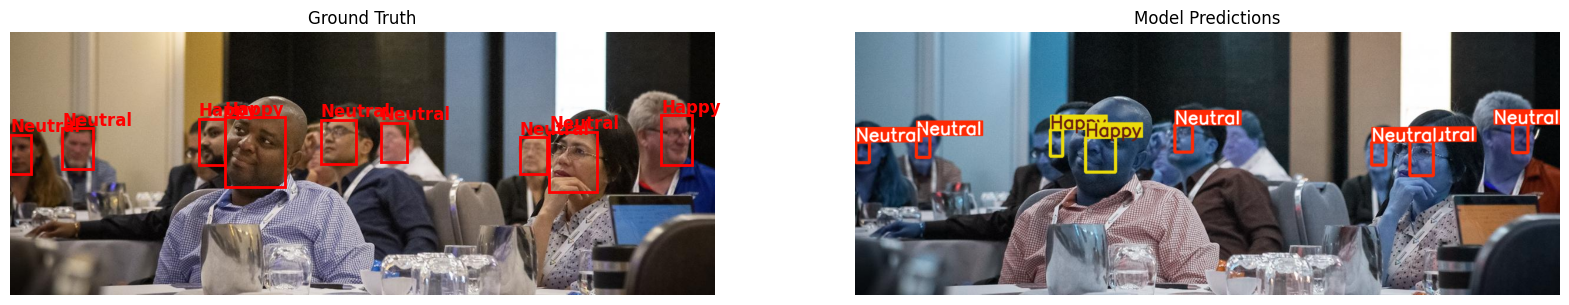

In [18]:
# @title
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

test = train_df.iloc[pic_id]

width = test['original_width']
height = test['original_height']

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the original image with ground truth bounding boxes on the left subplot
axes[0].imshow(Image.open(os.path.join(yolo_dir,'images','train',test['file_name'])))
axes[0].set_title('Ground Truth')
axes[0].axis("off")

for ind, bbox in enumerate(test['objects']['bbox']):
  bbox = np.array(bbox)/100
  x, y, w, h = bbox*[width,height,width,height]

  # Create a Rectangle patch
  rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  axes[0].add_patch(rect)

  # Add the emotion label
  emotion_label = test['objects']['categories'][ind]
  axes[0].text(x, y - 5, emotion_label, color='red', fontsize=12, weight='bold')


#Display the image with model predictions on the right subplot
axes[1].imshow(train_preds[pic_id].plot(conf = False, line_width = int(width*0.003))) # YOLO's plot method returns an image
axes[1].set_title('Model Predictions')
axes[1].axis("off")

plt.show()

### Training with KFolds

Below we will create stratified KFolds and split our images to train following this [guide](https://docs.ultralytics.com/guides/kfold-cross-validation/#k-fold-dataset-split) and this [package](https://github.com/trent-b/iterative-stratification).

In [19]:
df = pd.read_csv(meta_root/'train_meta.csv')
df['objects'] = df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
df['file_exists'] = df.apply(lambda x: os.path.exists(dataset_path/x.file_name),axis = 1)

# Drop rows where the file does not exist
df = df[df.file_exists]
df.drop(columns=['file_exists'], inplace=True)

df.head()

,file_name,objects,original_height,original_width,emotions
0,2w4w14gc7v0zzlo2hr.jpg,"{'bbox': [[53.203433030794265, 17.615104049146...",300,361,['Sad']
1,30nuw6i66lmickmbly.jpg,"{'bbox': [[26.798646725660358, 15.553243651943...",500,489,['Sad']
2,6ypnlgwpdwm4cxhzyq.jpg,"{'bbox': [[39.807704879496356, 5.2996237628844...",393,233,['Disgust']
3,7yfw4gdcdak0kdvqu2.jpg,"{'bbox': [[47.60784313725491, 6.43835340508561...",184,274,['Sad']
4,9uq1l58tusi8vij6ju.jpg,"{'bbox': [[38.745098039215634, 17.137253719272...",200,300,['Sad']


We create a dataframe whose indices are the pictures in our train set and has a column for each fold in our n-Fold Cross-Validation. The entry in each column determins if that picture belongs to the train or validation set in that corresponding fold.

In [20]:
index = list(df['file_name'])

mlb = MultiLabelBinarizer()

X = df[['file_name']]
y = mlb.fit_transform(df['emotions'])

ksplit = 5

msk = MultilabelStratifiedKFold(n_splits=ksplit, shuffle=True, random_state=42)
idx = np.arange(len(df))

folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=index, columns=folds)

kfolds = list(msk.split(idx, y))

#For every image, we write if they belong to "train" or "val" in each respective fold
for i, (train_idx, val_idx) in enumerate(kfolds, start=1):
    col = f"split_{i}"
    col_pos = folds_df.columns.get_loc(col)
    folds_df.iloc[train_idx,col_pos] = "train"
    folds_df.iloc[val_idx,col_pos] = "val"



We prepare the data for each split according to the `YOLO format`.

In [21]:
import datetime
import yaml

yaml_file = yolo_dir/"data.yaml"  # your data YAML with data directories and names dictionary

with open(yaml_file, encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]

# List with image file paths
images = list(df["file_name"].apply(lambda x: dataset_path/x))

# Create the necessary directories and dataset YAML files
save_path = yolo_dir / f"{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val"
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )

We now copy each image to their respective n-Fold Cross-Validation folder.

In [22]:
from tqdm import tqdm
import shutil

for image in tqdm(images, total=len(images), desc="Copying files"):
    for split, k_split in folds_df.loc[image.name].items():
        # Destination directory
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"

        # Copy image and label files to new directory (SamefileError if file already exists)
        shutil.copy(image, img_to_path / image.name)
        row = df.loc[df["file_name"] == image.name].iloc[0]
        label_content = label(row)
        with open(lbl_to_path/image.name.replace('.jpg', '.txt'), 'w') as f:
            f.write(label_content)

Copying files: 100%|██████████| 178/178 [00:12<00:00, 14.54it/s]


We now evaluate how the base YOLO model performs in n-fold cross validation.

In [23]:
results = {}

batch = 8
project = save_path/"runs"
epochs = 200
weights_path = 'yolo11n.pt'

for k, dataset_yaml in enumerate(ds_yamls):
    model = YOLO(weights_path, task="detect")
    results[k] = model.train(
        data=dataset_yaml, epochs=epochs, batch=batch, project=project, name=f"fold_{k + 1}", imgsz=1024, device=0, rect= True
    )

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_training/2025-11-06_5-Fold_Cross-val/split_1/split_1_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fold_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

A summary of our results for the n-Fold Cross-Validation.

In [24]:
ksplit = 5

results = []

for k in range(ksplit):
  results.append(pd.read_csv(project/f'fold_{k+1}'/'results.csv').iloc[-1])
results_df = pd.DataFrame(results,index=[f'fold_{k+1}' for k in range(ksplit)])
results_df.describe()


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,162.400000,401.982800,1.067846,0.804262,0.947432,0.226406,0.181508,0.128026,0.040952,2.534442,2.816808,1.913266,0.000183,0.000183,0.000183
std,32.951479,74.630565,0.153957,0.123209,0.051295,0.132640,0.046852,0.019908,0.009285,0.048846,0.208772,0.093750,0.000148,0.000148,0.000148
min,123.000000,312.834000,0.894530,0.677390,0.875540,0.123260,0.114600,0.106100,0.031850,2.457300,2.594700,1.748950,0.000014,0.000014,0.000014
25%,135.000000,340.278000,0.945730,0.706470,0.913770,0.131690,0.150420,0.108090,0.032650,2.524870,2.660780,1.932060,0.000072,0.000072,0.000072
50%,167.000000,412.427000,1.049600,0.773050,0.964210,0.146820,0.206800,0.133070,0.040440,2.537800,2.831440,1.941640,0.000162,0.000162,0.000162
75%,187.000000,455.493000,1.211820,0.906200,0.991090,0.310630,0.212630,0.145030,0.045890,2.573290,2.867440,1.963580,0.000306,0.000306,0.000306
max,200.000000,488.882000,1.237550,0.958200,0.992550,0.419630,0.223090,0.147840,0.053930,2.578950,3.129680,1.980100,0.000360,0.000360,0.000360


##Augmentations

Now we will test our n-fold cross validation using the following extra augmentations:

- Rotation `degrees=90`
- Translation `translate=0.3`
- Scale `scale=0.7`
- Shear `shear=30` (might want to skip this one)
- Flip Left-Right `flipr=1`

In [25]:
results = {}

batch = 8
project = save_path/"runs_aug"
epochs = 200
weights_path = 'yolo11n.pt'

for k, dataset_yaml in enumerate(ds_yamls):
    model = YOLO(weights_path, task="detect")
    results[k] = model.train(
        data=dataset_yaml, epochs=epochs, batch=batch, project=project, name=f"fold_{k + 1}", imgsz=1024, device=0, rect= True,
        degrees=30,
        translate=0.3,
        scale=0.7,
        shear=30,
        fliplr=1
    )  # include any additional train arguments

Streaming output truncated to the last 5000 lines.
      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     27/200      4.41G      2.224      3.423      1.497          9        704: 100% ━━━━━━━━━━━━ 18/18 9.7it/s 1.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 12.9it/s 0.2s
                   all         35        193      0.636      0.109     0.0547     0.0139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     28/200      4.41G      2.139      3.383      1.616          8        704: 100% ━━━━━━━━━━━━ 18/18 9.9it/s 1.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 12.1it/s 0.2s
                   all         35        193       0.65      0.124     0.0638     0.0155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     29/200      4.41G      2.193      3.385      1

In [26]:
ksplit = 5

results_aug = []

for k in range(ksplit):
  results_aug.append(pd.read_csv(project/f'fold_{k+1}'/'results.csv').iloc[-1])
results_aug_df = pd.DataFrame(results_aug,index=[f'fold_{k+1}' for k in range(ksplit)])
results_aug_df.describe()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,193.200000,483.339800,1.647080,1.471366,1.256062,0.282544,0.231504,0.163624,0.051150,2.57504,2.340068,1.713672,0.000044,0.000044,0.000044
std,15.205262,39.876604,0.044356,0.073222,0.061312,0.154683,0.047343,0.042564,0.017264,0.11906,0.144960,0.109500,0.000068,0.000068,0.000068
min,166.000000,412.337000,1.608770,1.416270,1.202760,0.140990,0.175560,0.111510,0.031000,2.45940,2.164560,1.582190,0.000014,0.000014,0.000014
25%,200.000000,494.622000,1.624000,1.433300,1.224150,0.165210,0.217470,0.147040,0.043340,2.48659,2.237020,1.619660,0.000014,0.000014,0.000014
50%,200.000000,501.945000,1.627900,1.446370,1.224730,0.247760,0.228560,0.154120,0.049490,2.56375,2.333050,1.750810,0.000014,0.000014,0.000014
75%,200.000000,503.399000,1.653780,1.462050,1.273080,0.335650,0.229420,0.179190,0.054050,2.60468,2.452800,1.770990,0.000014,0.000014,0.000014
max,200.000000,504.396000,1.720950,1.598840,1.355590,0.523110,0.306510,0.226260,0.077870,2.76078,2.512910,1.844710,0.000167,0.000167,0.000167


We see that every metric, except Precision, improved:

| Metric    | No Aug  | With Aug  | Result    |
| ---       | ---     | ---       | ---       |
| Precision | 0.2296  | 0.2234    | Decreased |
| Recall    |  0.1469 | 0.1819    | Increased |
| mAP50     |  0.1046 | 0.1323    | Increased |
| mAP50-95  | 0.0326  | 0.0408    | Increased |

##Hyperparameter tuning

Now we proceed to try some hyperparameter tunning. We will use the search space in the cell below.

In [27]:
search_space = {
    "lr0":        (1e-5, 1e-1),
    "degrees":    (0.0,30.0),
    "translate":  (0.0, 0.7),
    "scale":      (0.5, 1.5),
    "shear":      (0.0, 30),
    "fliplr":      (0.0,1.0),
    "flipud":     (0.0,1.0),
    "box":        (0.02,0.2),
    "cls":        (0.2,4.0)
}

In [28]:
batch = 8
project = yolo_dir/"tune"
epochs = 30
weights_path = 'yolo11n.pt'
iterations = 20

model = YOLO(weights_path, task="detect")
model.tune(data=yolo_dir/'data.yaml', epochs=epochs, batch=batch, space=search_space ,project=project, imgsz=1024, device=0, optimizer="AdamW", iterations = iterations
    )

Tuner: Initialized Tuner instance with 'tune_dir=/content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune3'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/20 with hyperparameters: {'lr0': 0.01, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'fliplr': 0.5, 'flipud': 0.0, 'box': 0.2, 'cls': 0.5}
Saved /content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune3/tune_scatter_plots.png
Saved /content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune3/tune_fitness.png

Tuner: 1/20 iterations complete ✅ (136.04s)
Tuner: Results saved to /content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune3
Tuner: Best fitness=0.03171 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.77162, 'metrics/recall(B)': 0.16059, 'metrics/mAP50(B)': 0.10219, 'metrics/mAP

We will use the found hyperparameters to train a bigger model, `yolo11m.pt` and compare its performance.

In [29]:
import yaml

# Load the best hyperparameters from the generated YAML file
best_hyperparameters_path = yolo_dir/ 'tune' / 'tune3' / 'best_hyperparameters.yaml' # Assuming 'tune2' is the name of the tuning run directory
with open(best_hyperparameters_path, encoding="utf8") as y:
    best_hyperparameters = yaml.safe_load(y)

# Now train the yolo11m model using the best hyperparameters
batch = 8
project = yolo_dir/'runs'
epochs = 150
name = 'yolo11m_finetuned'
weights_path = 'yolo11m.pt'

model = YOLO(weights_path, task="detect")
model.train(data=yolo_dir/'data.yaml', epochs=epochs, batch=batch, project=project, name=name, imgsz=1024, device=0, rect= True, **best_hyperparameters)

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=0.2, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_training/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.4465, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00728, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_finetuned4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7842e9930a40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [16]:
project = yolo_dir/'runs'
name = 'yolo11m_finetuned'
results_path = project / f"{name}" / "results.png"

display(Image(filename=results_path, width=1000))

TypeError: 'module' object is not callable

We also test the `yolov11m-face.pt` model. This model was solely trained to detect faces.

In [30]:
# Now train the yolo11m model using the best hyperparameters
batch = 8
project = yolo_dir/'runs'
epochs = 150

name = 'yolo11m_face_finetuned'
weights_path = 'yolov11m-face.pt'

model = YOLO(weights_path, task="detect")
model.train(data=yolo_dir/'data.yaml', epochs=epochs, batch=batch, project=project, name=name, imgsz=1024, device=0, rect= True, **best_hyperparameters)

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=0.2, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_training/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.4465, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00728, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov11m-face.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_face_finetuned2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7843d1c9ffb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [ ]:
project = yolo_dir/'runs'
name = 'yolo11m_face_finetuned'
results_path = project / f"{name}" / "results.png"

display(Image(filename=results_path, width=1000))

We finally get the following resulting metrics for `yolo11m.pt`:

| Metric | Value |
| --- | --- |
| Precision |  0.279 |
| Recall| 0.191|
| mAP50|      0.197|
| mAP50-95|   0.0654|

Note that this is better in every metric to what we achieved with the smaller model `yolo11n.pt`.

Using the face recognition model `yolov11m-face.pt` we get the following resulting metrics:

| Metric | Value |
| --- | --- |
| Precision |  0.429 |
| Recall| 0.212|
| mAP50|      0.212|
| mAP50-95|   0.0802|

Note that this is better in every metric to what we achieved with the smaller model `yolov11n-face.pt`.

In [31]:
from google.colab import runtime
runtime.unassign()